### 1.Load small offline dataset, get graphs list

In [477]:
small_offline_networks = pd.read_csv(DATA_DIR_PATH / "small_offline_social_networks.csv")
small_offline_networks['nodes_qcut']='small'

In [387]:
import os
import scipy.stats as sp
from os.path import join
import networkx.algorithms.community as nxcom
import pathlib
import subprocess 
from lib import *
from pathcensus import PathCensus
from pathcensus.nullmodels import UBCM
from pathcensus.inference import Inference
from pathcensus.utils import set_seed
import joblib
import numpy as np
import matplotlib.pyplot as plt
from random import randint
import matplotlib.patches as mpatches


In [227]:
small_offline_networks_path_base=r"C:\Users\hajiabukar_s\Network_Science\Final_Project\Us\data\offline\small"
small_offline_networks_path_list=[]
name_list=[]
name_list_networks_used_given=[]
small_offline_networks_names_list=[]
for root, dirs, files in os.walk(small_offline_networks_path_base):
    for name in files:
        if name.endswith((".gml")):
            name_help="_"+name
            name1=root[len(small_offline_networks_path_base)+1:]
            name2=name[:len(name)-4]
            name_list_networks_used_given.append(name2)
            if(name1==name2):
                name_help=""
            name_list.append(root[len(small_offline_networks_path_base)+1:]+name_help)
            small_offline_networks_path_list.append(os.path.join(root, name))
            small_offline_networks_names_list.append(name)

In [208]:
g1=nx.read_gml(gml_cleaner(small_offline_networks_path_list[1]), label="id")
g2=nx.read_gml(gml_cleaner(small_offline_networks_path_list[2]), label="id")
g3=nx.read_gml(gml_cleaner(small_offline_networks_path_list[3]), label="id")
g4=nx.read_gml(gml_cleaner(small_offline_networks_path_list[4]), label="id")
g6=nx.read_gml(gml_cleaner(small_offline_networks_path_list[6]), label="id")

In [218]:
set_seed(1019)
N_SAMPLES = 200
results = []
graph_name_list=[]
name_graph_dict={}
for i in name_list:
    graph_name_list.append("g_"+i)
l=0
loaded_graphs_name_list=[]
for j in range(0,len(small_offline_networks_path_list)):
    try:
        loaded_graphs_name_list.append(graph_name_list[j])
        graph_name_list[j]=nx.read_gml(gml_cleaner(small_offline_networks_path_list[j]), label="id")
        name_graph_dict[loaded_graphs_name_list[l]]=graph_name_list[j]
        l=l+1

    except:
        continue
graph_name_list_o=graph_name_list
graph_name_list=[]

for m in range(len(graph_name_list_o)):
    if not isinstance(graph_name_list_o[m],str):
        graph_name_list.append(graph_name_list_o[m])

loaded_graphs_name_list=list(name_graph_dict.keys())

### 2. Exploration

### 2.1. overview of networks

In [8]:
small_offline_networks

,group,name,nodes,edges,avg_degree,std_dev_degree,largest_eigenvalue_hashimoto,random_walk_mixing_time,degree_assortativity,global_clustering,diameter,relative_size_of_largest_component,kind,mode,node_properties,edge_properties,gml_file_size,nodes_qcut
0,dutch_criticism,dutch_criticism,35,81,4.63,2.97,5.57,5.29,0.04,0.16,7,1.0,Undirected,Unipartite,id name x y z,weight,2 KiB,small
1,karate,77,34,77,4.53,3.75,5.25,6.98,-0.47,0.26,5,1.0,Undirected,Unipartite,name groups,NaN,1 KiB,small
2,karate,78,34,78,4.59,3.82,5.29,7.05,-0.48,0.26,5,1.0,Undirected,Unipartite,name groups,NaN,1 KiB,small
3,november17,november17,22,66,6.00,3.58,6.78,2.67,-0.25,0.53,4,1.0,Undirected,Unipartite,name Role Faction Resources,NaN,1 KiB,small
4,sp_hospital,sp_hospital,75,32424,864.64,956.79,35.91,3.44,0.09,0.75,3,1.0,Undirected,Unipartite,id status,time,99 KiB,small
5,sp_kenyan_households,sp_kenyan_households,47,32643,1389.06,1229.28,22.98,5.12,0.27,0.74,3,1.0,Undirected,Unipartite,id house age sex,duration day hour,50 KiB,small
6,terrorists_911,terrorists_911,62,152,4.90,4.00,7.25,19.05,-0.08,0.36,5,1.0,Undirected,Unipartite,id name group,NaN,2 KiB,small


### 2.2. Number of small offline networks 

In [125]:
print("Number of small offline social networks we use: ", len(loaded_graphs_name_list))

Number of small offline social networks we use:  7


### 2.3.  Check if all networks are undirected and unweighted

In [219]:
weight_bool=True
directed_bool=True
graph_name_list
for g in graph_name_list:
    if(nx.is_weighted(g)):
        weight_bool=False
    if(nx.is_directed(g)):
        directed_bool=False
print("Are all graphs unweighted? ", weight_bool)

print("Are all graphs undirected? ", directed_bool)


Are all graphs unweighted?  True
Are all graphs undirected?  True


### 2.4. Number of small online networks Bipartite, Unpartite Networks

Text(0.5, 1.0, 'Counts of network modes of small offline networks')

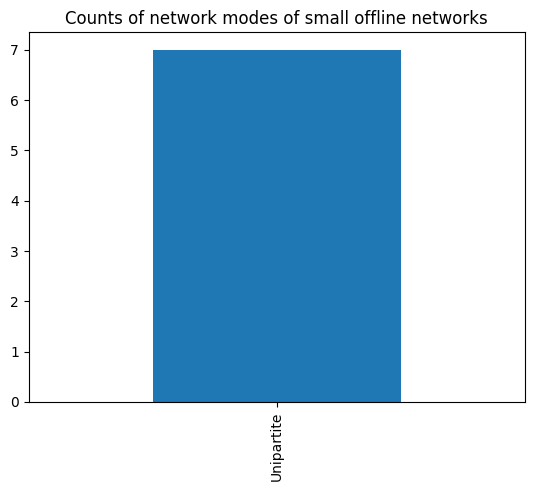

In [222]:
small_offline_networks["mode"].value_counts().sort_values().plot(kind = 'bar')
plt.title("Counts of network modes of small offline networks")

### 2.5. Visualization of graphs

In [343]:
#def ploter function
def ploter(graph_list,graph_name_list, title):
    ax_list=["ax"+str(i) for i in range(len(graph_list))]
    subplot_list=[230+i for i in range(1,len(graph_list)+1)]
    fig = plt.figure(figsize = (30,30))
    fig.suptitle(title)
    i=0
    for i in range(len(ax_list)):
        pos = nx.spring_layout(graph_list[i], iterations=15, seed=1721)
        ax_list[i] = fig.add_subplot(subplot_list[i])
        ax_list[i].set_title(loaded_graphs_name_list[i])
        nx.draw_networkx(graph_list[i], pos=pos, ax=ax_list[i])

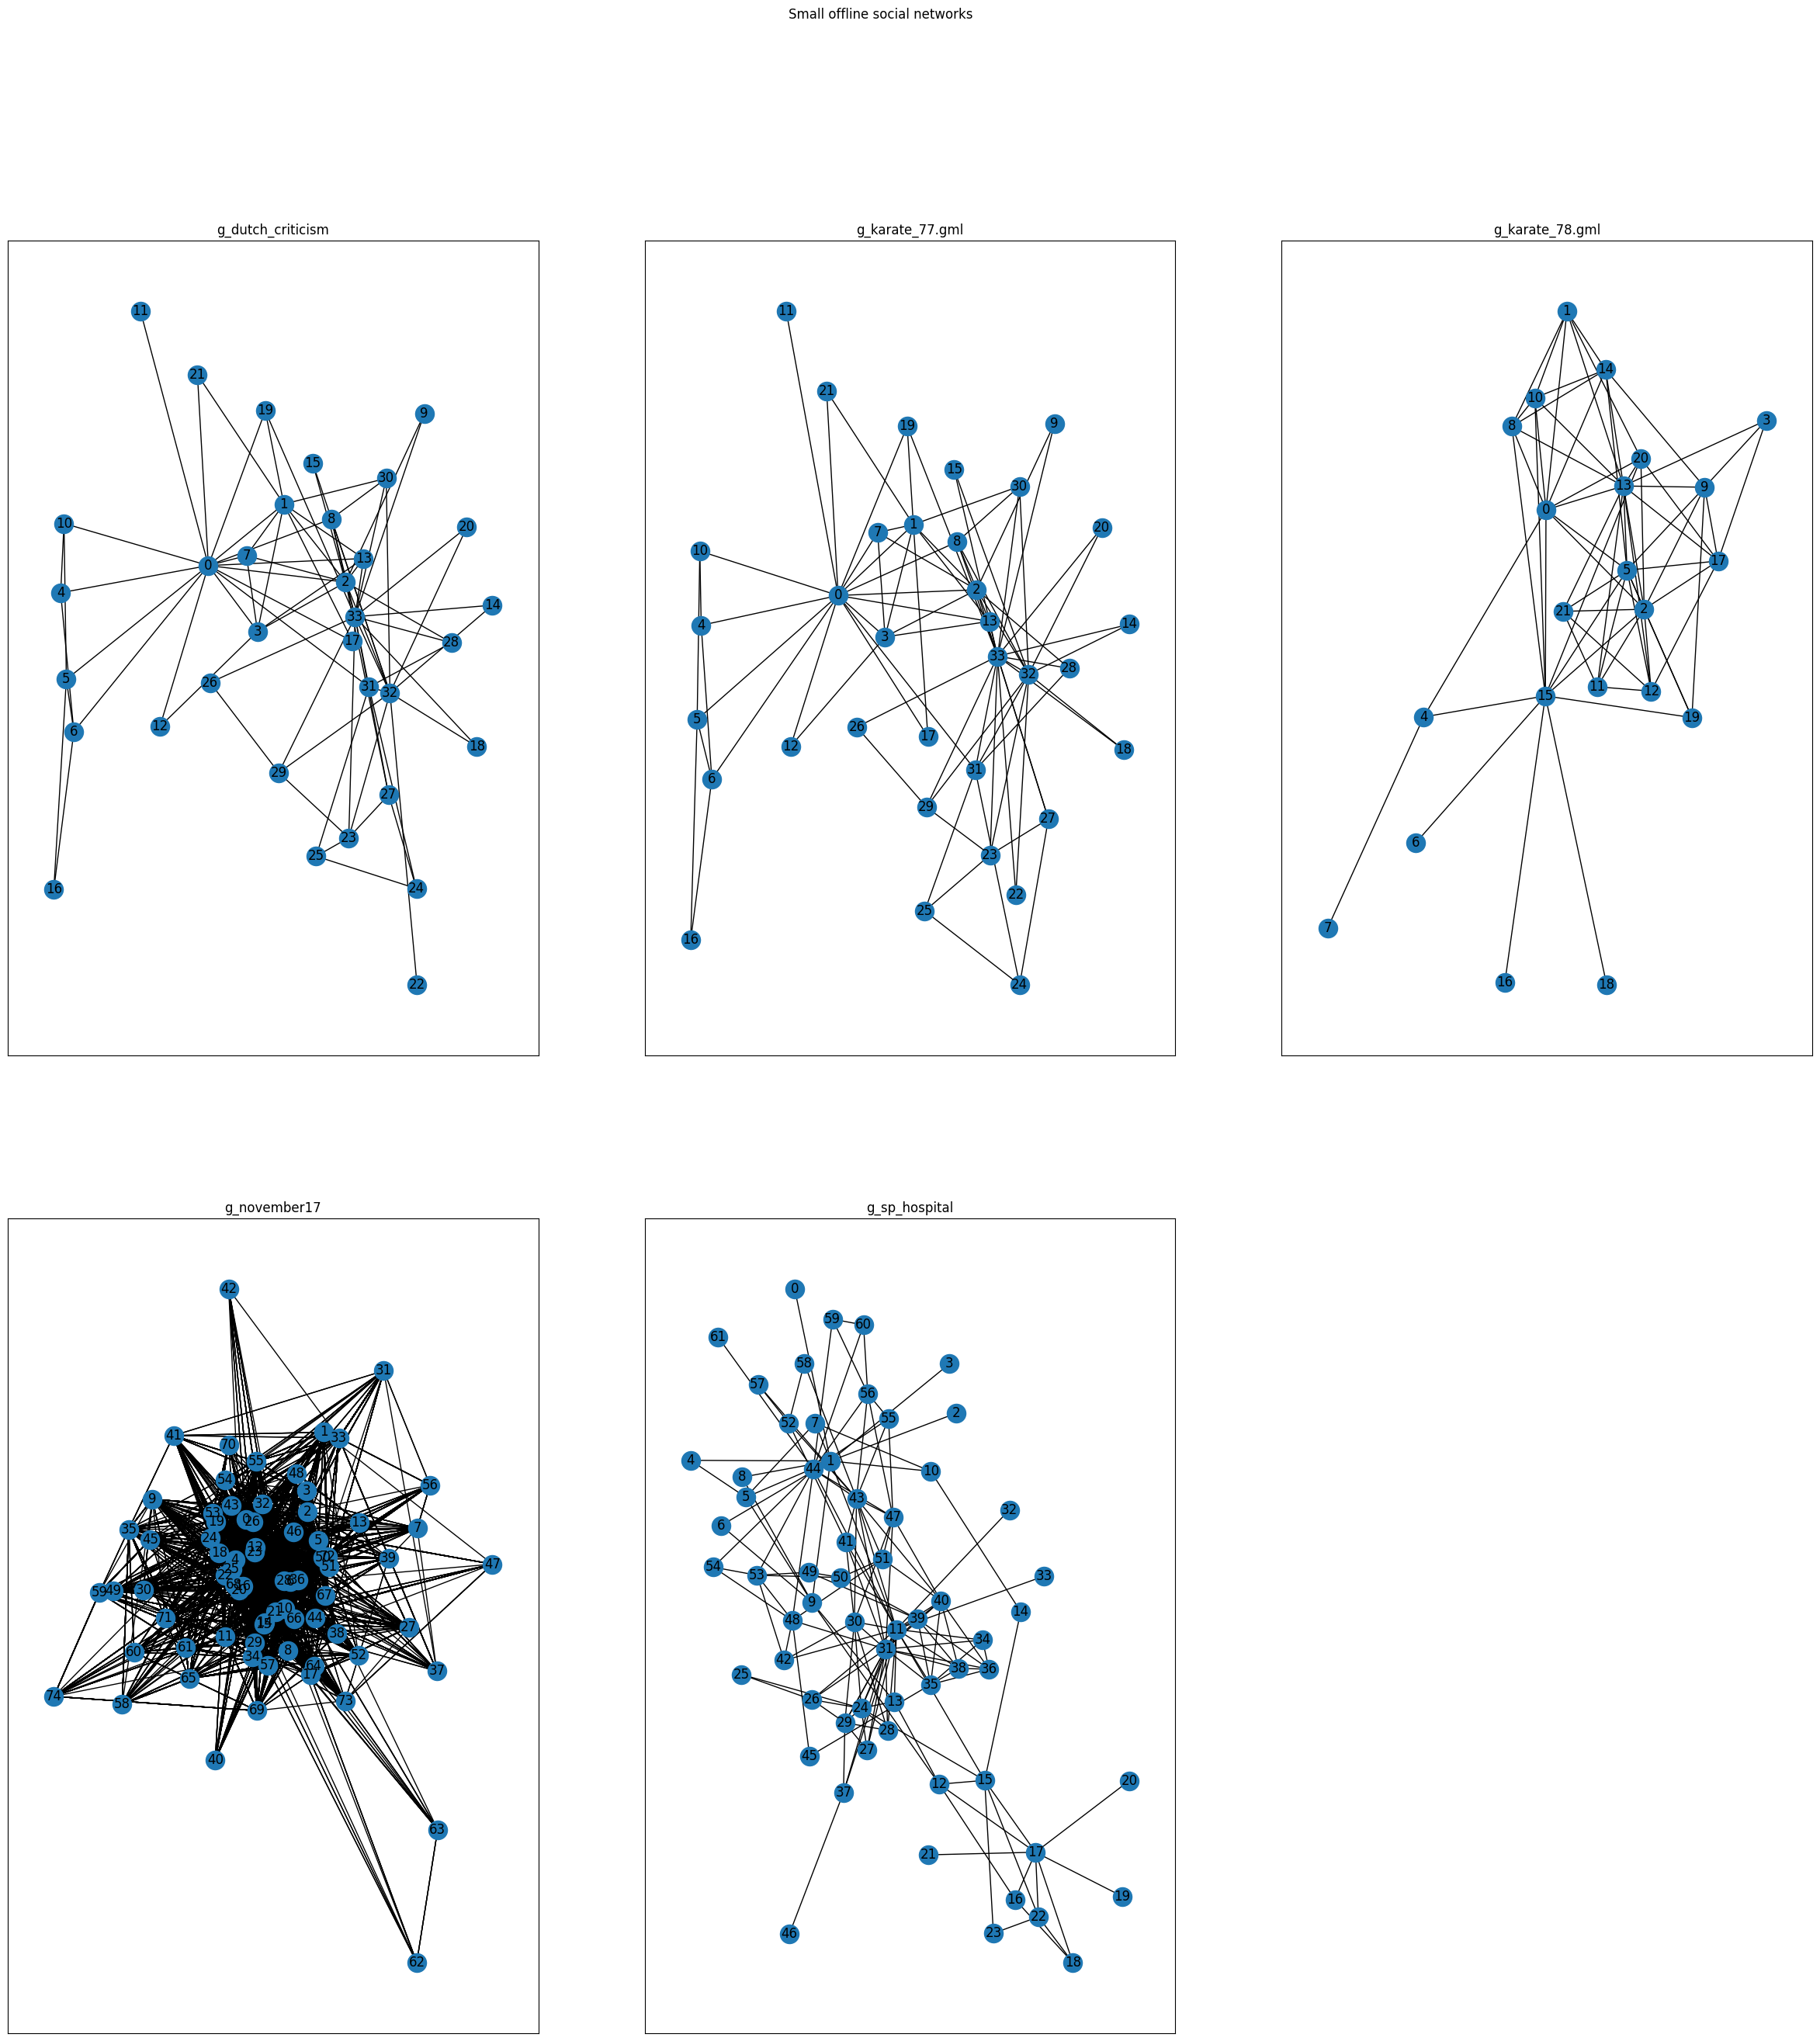

In [344]:
ploter(graph_name_list,loaded_graphs_name_list,"Small offline social networks")

### 2.5. Creating list for given values of the networks

In [238]:
#df used
df_used=small_offline_networks.loc[small_offline_networks['name'].isin(name_list_networks_used_given)]

#diamater_list
diamater_list=list(df_used['diameter'])

#number of nodes list
number_of_nodes_list=list(df_used['nodes'])

#number of edges list
number_of_edges_list=list(df_used['edges'])

#avgerage degree list
number_of_nodes_list=list(df_used['avg_degree'])

#std_deve_degree list
number_of_nodes_list=list(df_used['std_dev_degree'])

#largest eigenvalue hashimoto list
number_of_nodes_list=list(df_used['largest_eigenvalue_hashimoto'])

#random walk mixing time list
number_of_nodes_list=list(df_used['random_walk_mixing_time'])

#degree assortativity list
number_of_nodes_list=list(df_used['degree_assortativity'])

#global clustering list
number_of_nodes_list=list(df_used['global_clustering'])

#relative size of largest component list
number_of_nodes_list=list(df_used['relative_size_of_largest_component'])

### 2.6. Community detection

### 2.6.1 community detection functions

In [276]:
#random color generator
def random_color_generator():
    import random
    for i in range(3):
        r = random.randint(0,255)
        g = random.randint(0,255)
        b = random.randint(0,255)
        rgb = [r,g,b]
    from colormap import rgb2hex
    return rgb2hex(rgb[0],rgb[1],rgb[2])

In [277]:
def nodes_coloring(graph,communities_dict):
    for coms in communities_dict:
        random_color=random_color_generator()
        try:
            for knoten in list(coms):
                graph.nodes[knoten]['color']=random_color
        except:
             for coms2 in list(communities_dict):
                graph.nodes[coms2]['color']=random_color

In [346]:
#function that finds the max modularity community for the girvan newman algorithm
def max_modularity_community_partition_gn(graph):
    #getting all communities determined by the girvan newman algorithm
    com_dolphin_gn=nxcom.girvan_newman(graph)
    #get modularity of each community partition
    list_modularity=[]
    for val in com_dolphin_gn:
        list_modularity.append(nxcom.modularity(graph,val))
    #finding community partition with the max modularity
    index_max = np.argmax(list_modularity)
    i=0
   
    for j in list(nxcom.girvan_newman(graph)):
        if i==index_max:
            max_com_graph=j
            break
        else:
            i=i+1
    for m in max_com_graph:
        return j

In [357]:
def plotter_community_detection(g_list,network_name,title):
    #a)getting the communities using the greedy modularity maximization by Clauset Newman and Moore
  dict_com_cn_list=[nxcom.greedy_modularity_communities(g) for g in g_list]

  #b)getting the communities using the the Girvan-Newman algorithm
  dict_com_gn_list=[max_modularity_community_partition_gn(g) for g in g_list]

  #c) get the community numbers
  num_com_cn_list=[len(dict_com_cn_list[i]) for i in range(len(g_list))]
  num_com_gn_list=[len(dict_com_gn_list[i]) for i in range(len(g_list))]

  subplot_title_list=[]
  subplot_title_list.append("greedy modularity maximization by CNM, num of communities: "+str(num_com_cn_list))
  subplot_title_list.append("girvan newman alg. using the com. part. with the max modularity, num of communities: "+str(num_com_gn_list))

  ax_list=["ax"+str(i) for i in range(len(g_list))]
  subplot_list=[230+i for i in range(1,len(g_list)+1)]
  fig = plt.figure(figsize = (30,30))
  fig.suptitle(title)
  i=0
  for i in range(len(ax_list)):
      pos = nx.spring_layout(g_list[i], iterations=15, seed=1721)
      ax_list[i] = fig.add_subplot(subplot_list[i])
      ax_list[i].set_title(loaded_graphs_name_list[i])
      [nodes_coloring(g_list[i],dict_com_gn_list[i]) for i in range(len(g_list))]
      nx.draw(g_list[i], pos, ax = ax_list[i], with_labels = True,node_color = [g_list[i].nodes[knoten]['color'] for knoten in g_list[i].nodes()])



### 2.6.2 community detection with greedy modularity maximizationy CNM and girvan newmann alg.

In [368]:
plotter_community_detection(graph_name_list,loaded_graphs_name_list,"Small offline social networks")

KeyboardInterrupt: 

### 2.7 Centrality correlations

#### 2.7.1 Centrality correlations Functions

In [361]:
def coefficient_calulator_val(dict1,dict2):
    xdata=list(dict1.values())
    ydata=list(dict2.values())
    pearson=sp.pearsonr(xdata,ydata)[0]
    spearman=sp.spearmanr(xdata,ydata)[0]
    kendall=sp.kendalltau(xdata,ydata)[0]
    data={"pearson":pearson,"spearman":spearman,"kendall":kendall}
    return data

In [381]:
degree_list = [nx.degree_centrality(g) for g in graph_name_list]
between_list = [nx.betweenness_centrality(g) for g in graph_name_list]
close_list = [nx.closeness_centrality(g) for g in graph_name_list]

In [383]:
deg_close_coef_g_list=[coefficient_calulator_val(degree_list[i],close_list[i]) for i in range(len(graph_name_list))]
deg_betw_coef_g_list=[coefficient_calulator_val(degree_list[i],between_list[i])for i in range(len(graph_name_list))]
close_betw_coef_g_list=[coefficient_calulator_val(close_list[i],between_list[i])for i in range(len(graph_name_list))]

In [388]:
pearson1_list = [mpatches.Patch(color='black', label="Pearson's correlation "+str(deg_close_coef_g_list[i]['pearson'])) for i in range(len(graph_name_list))]
spearman1_list = [mpatches.Patch(color='red', label="Spearman's rho "+str(deg_close_coef_g_list[i]['spearman'])) for i in range(len(graph_name_list))]
kendall1_list = [mpatches.Patch(color='yellow', label="Kendall's tau "+str(deg_close_coef_g_list[i]['kendall'])) for i in range(len(graph_name_list))]

pearson2_list = [mpatches.Patch(color='black', label="Pearson's correlation "+str(deg_betw_coef_g_list[i]['pearson'])) for i in range(len(graph_name_list))]
spearman2_list = [mpatches.Patch(color='red', label="Spearman's rho "+str(deg_betw_coef_g_list[i]['spearman'])) for i in range(len(graph_name_list))]
kendall2_list = [mpatches.Patch(color='yellow', label="Kendall's tau "+str(deg_betw_coef_g_list[i]['kendall'])) for i in range(len(graph_name_list))]


pearson4_list = [mpatches.Patch(color='black', label="Pearson's correlation "+str(close_betw_coef_g_list[i]['pearson'])) for i in range(len(graph_name_list))]
spearman4_list = [mpatches.Patch(color='red', label="Spearman's rho "+str(close_betw_coef_g_list[i]['spearman'])) for i in range(len(graph_name_list))]
kendall4_list = [mpatches.Patch(color='yellow', label="Kendall's tau "+str(close_betw_coef_g_list[i]['kendall'])) for i in range(len(graph_name_list))]

perason_list_list=[pearson1_list,pearson2_list,pearson4_list]
spearman_list_list=[spearman1_list,spearman2_list,spearman4_list]
kendall_list_list=[kendall1_list,kendall2_list,kendall4_list]

In [466]:
import matplotlib.patches as mpatches

#def ploter function
def ploter_centrality_plots(g_list,graph_name_list, title):
    title_list=[]
    l=0
    for i in range(5):
        title_list.append(graph_name_list[i] +'\n'+ "Deg. C. vs Close C. with cor. coef.")
        title_list.append(graph_name_list[i]+'\n'+ "Deg. C. vs Betw. C. with cor. coef.")
        title_list.append(graph_name_list[i]+'\n'+'Close. C. vs Betw. C. with cor. coef.')

    x_label_list=[]
    y_label_list=[]

    x_label_list=["Degree Centrality","Degree Centrality","Closeness centrality"]
    y_label_list=["Closeness Centrality","Betweenness Centrality","Degree Centrality"]


    fig_list=["fig"+str(i) for i in range(len(g_list))]
    fig_created_list=[]
    fig, axs = plt.subplots(5, 3, figsize=(15,40))
    j=-1
    for i in range(5):
        axs[i,0].plot(list(degree_list[i].values()), list(close_list[i].values()), 'bo', markersize=2)
        axs[i,1].plot(list(degree_list[i].values()), list(between_list[i].values()), 'bo', markersize=2)
        axs[i,2].plot(list(close_list[i].values()), list(between_list[i].values()), 'bo', markersize=2)
        j=j+1
        axs[i,0].set_title(title_list[j])
        j=j+1
        axs[i,1].set_title(title_list[j])
        j=j+1
        axs[i,2].set_title(title_list[j])
        axs[i,0].legend(handles=[perason_list_list[0][i],spearman_list_list[0][i],kendall_list_list[0][i]])
        axs[i,1].legend(handles=[perason_list_list[1][i],spearman_list_list[1][i],kendall_list_list[1][i]])
        axs[i,2].legend(handles=[perason_list_list[2][i],spearman_list_list[2][i],kendall_list_list[2][i]])

        axs[i,0].set(xlabel=x_label_list[0],ylabel=y_label_list[0])
        axs[i,1].set(xlabel=x_label_list[0],ylabel=y_label_list[1])
        axs[i,2].set(xlabel=x_label_list[0],ylabel=y_label_list[2])



#### 2.7.2 Centrality correlations plot

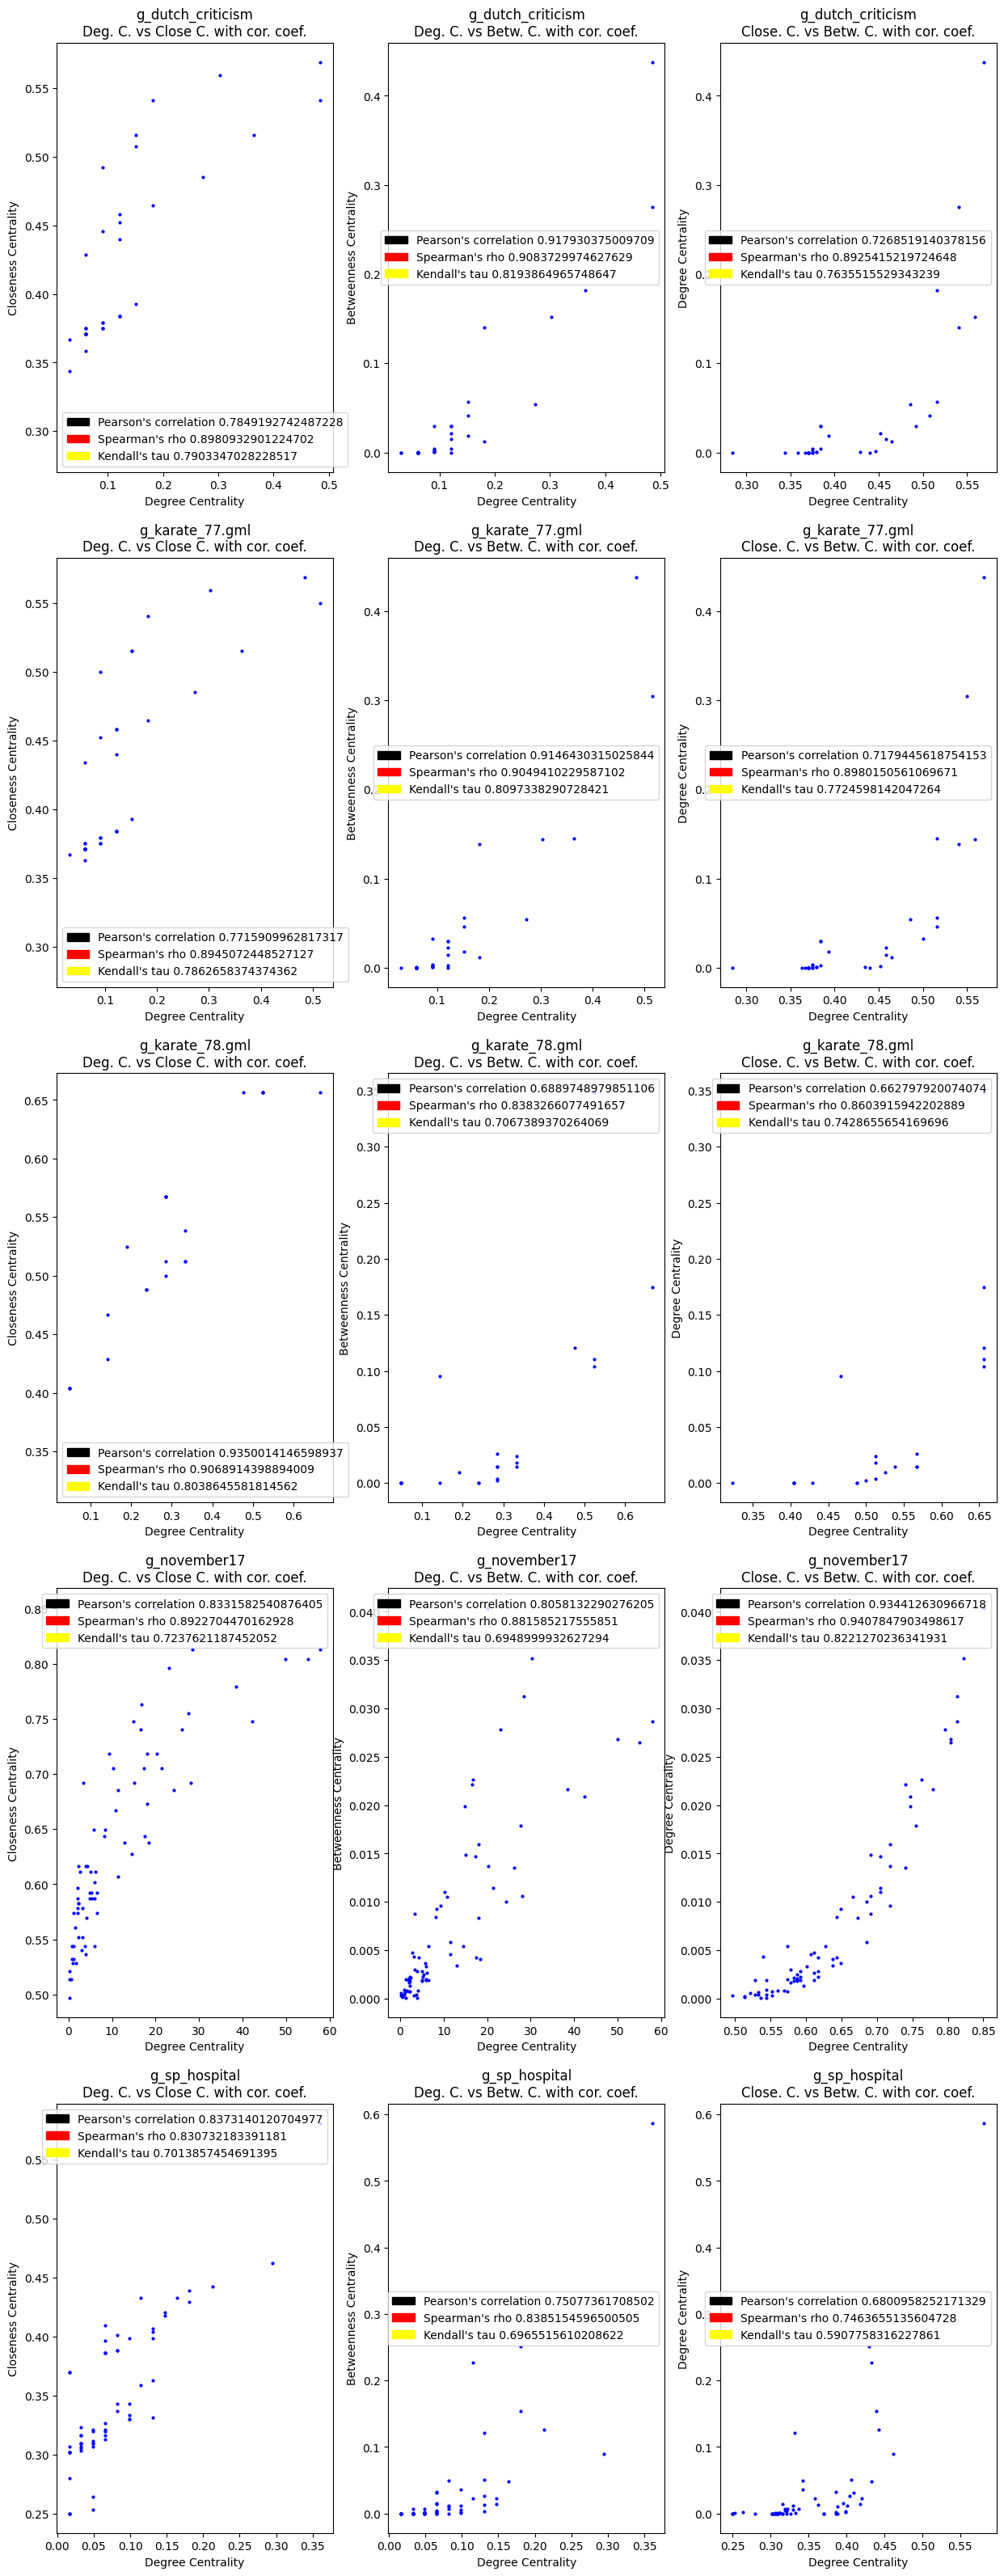

In [467]:
ploter_centrality_plots(graph_name_list,loaded_graphs_name_list, "Centrality correlations plot")

### 2.8. Histogramme

#### 2.8.1 Histogramm plotter Function

In [500]:
#def ploter function
def histogramm_plotter(graph_list,graph_name_list, values_list, xlabel, ylabel, title,bins):
    ax_list=["ax"+str(i) for i in range(len(graph_list))]
    subplot_list=[230+i for i in range(1,len(graph_list)+1)]
    fig = plt.figure(figsize = (20,20))
    fig.suptitle(title)
    i=0
    for i in range(len(ax_list)):
        ax_list[i] = fig.add_subplot(subplot_list[i])
        ax_list[i].set_title(loaded_graphs_name_list[i])
        ax_list[i].set(xlabel=xlabel+'(log)', ylabel=ylabel+'(log)', xscale = 'log', yscale = 'log')
        ax_list[i].hist(values_list[i].values(), bins=bins)


#### 2.8.2 Degree Centrality Histogramm

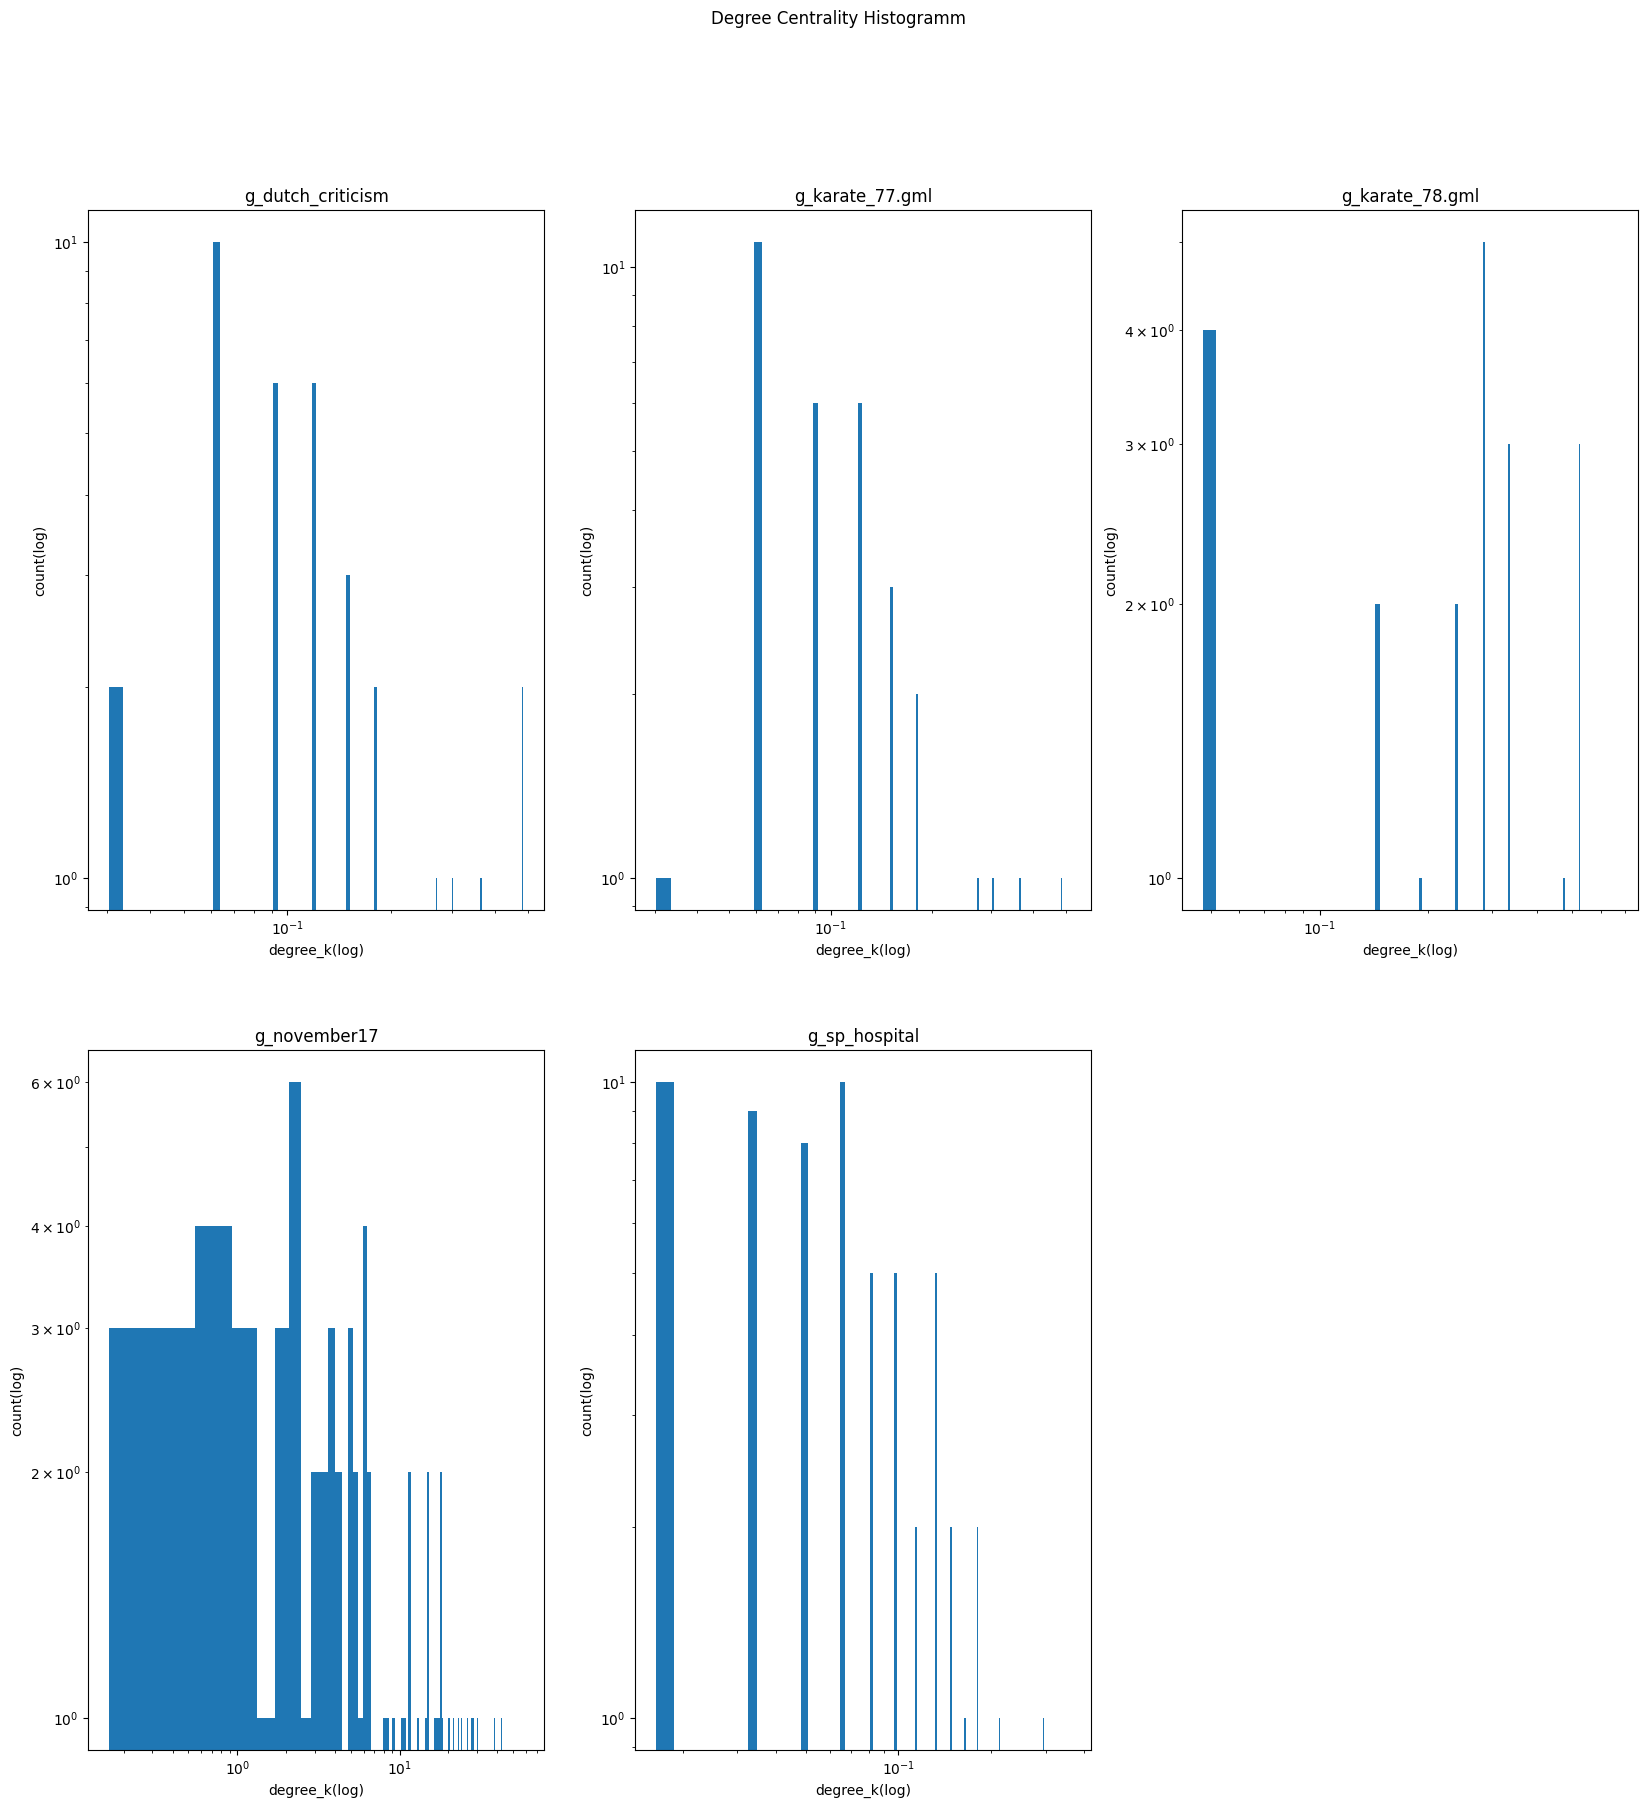

In [502]:
histogramm_plotter(graph_name_list,loaded_graphs_name_list, degree_list,"degree_k","count","Degree Centrality Histogramm",150)

#### 2.8.3 Betweeness Centrality Histogramm

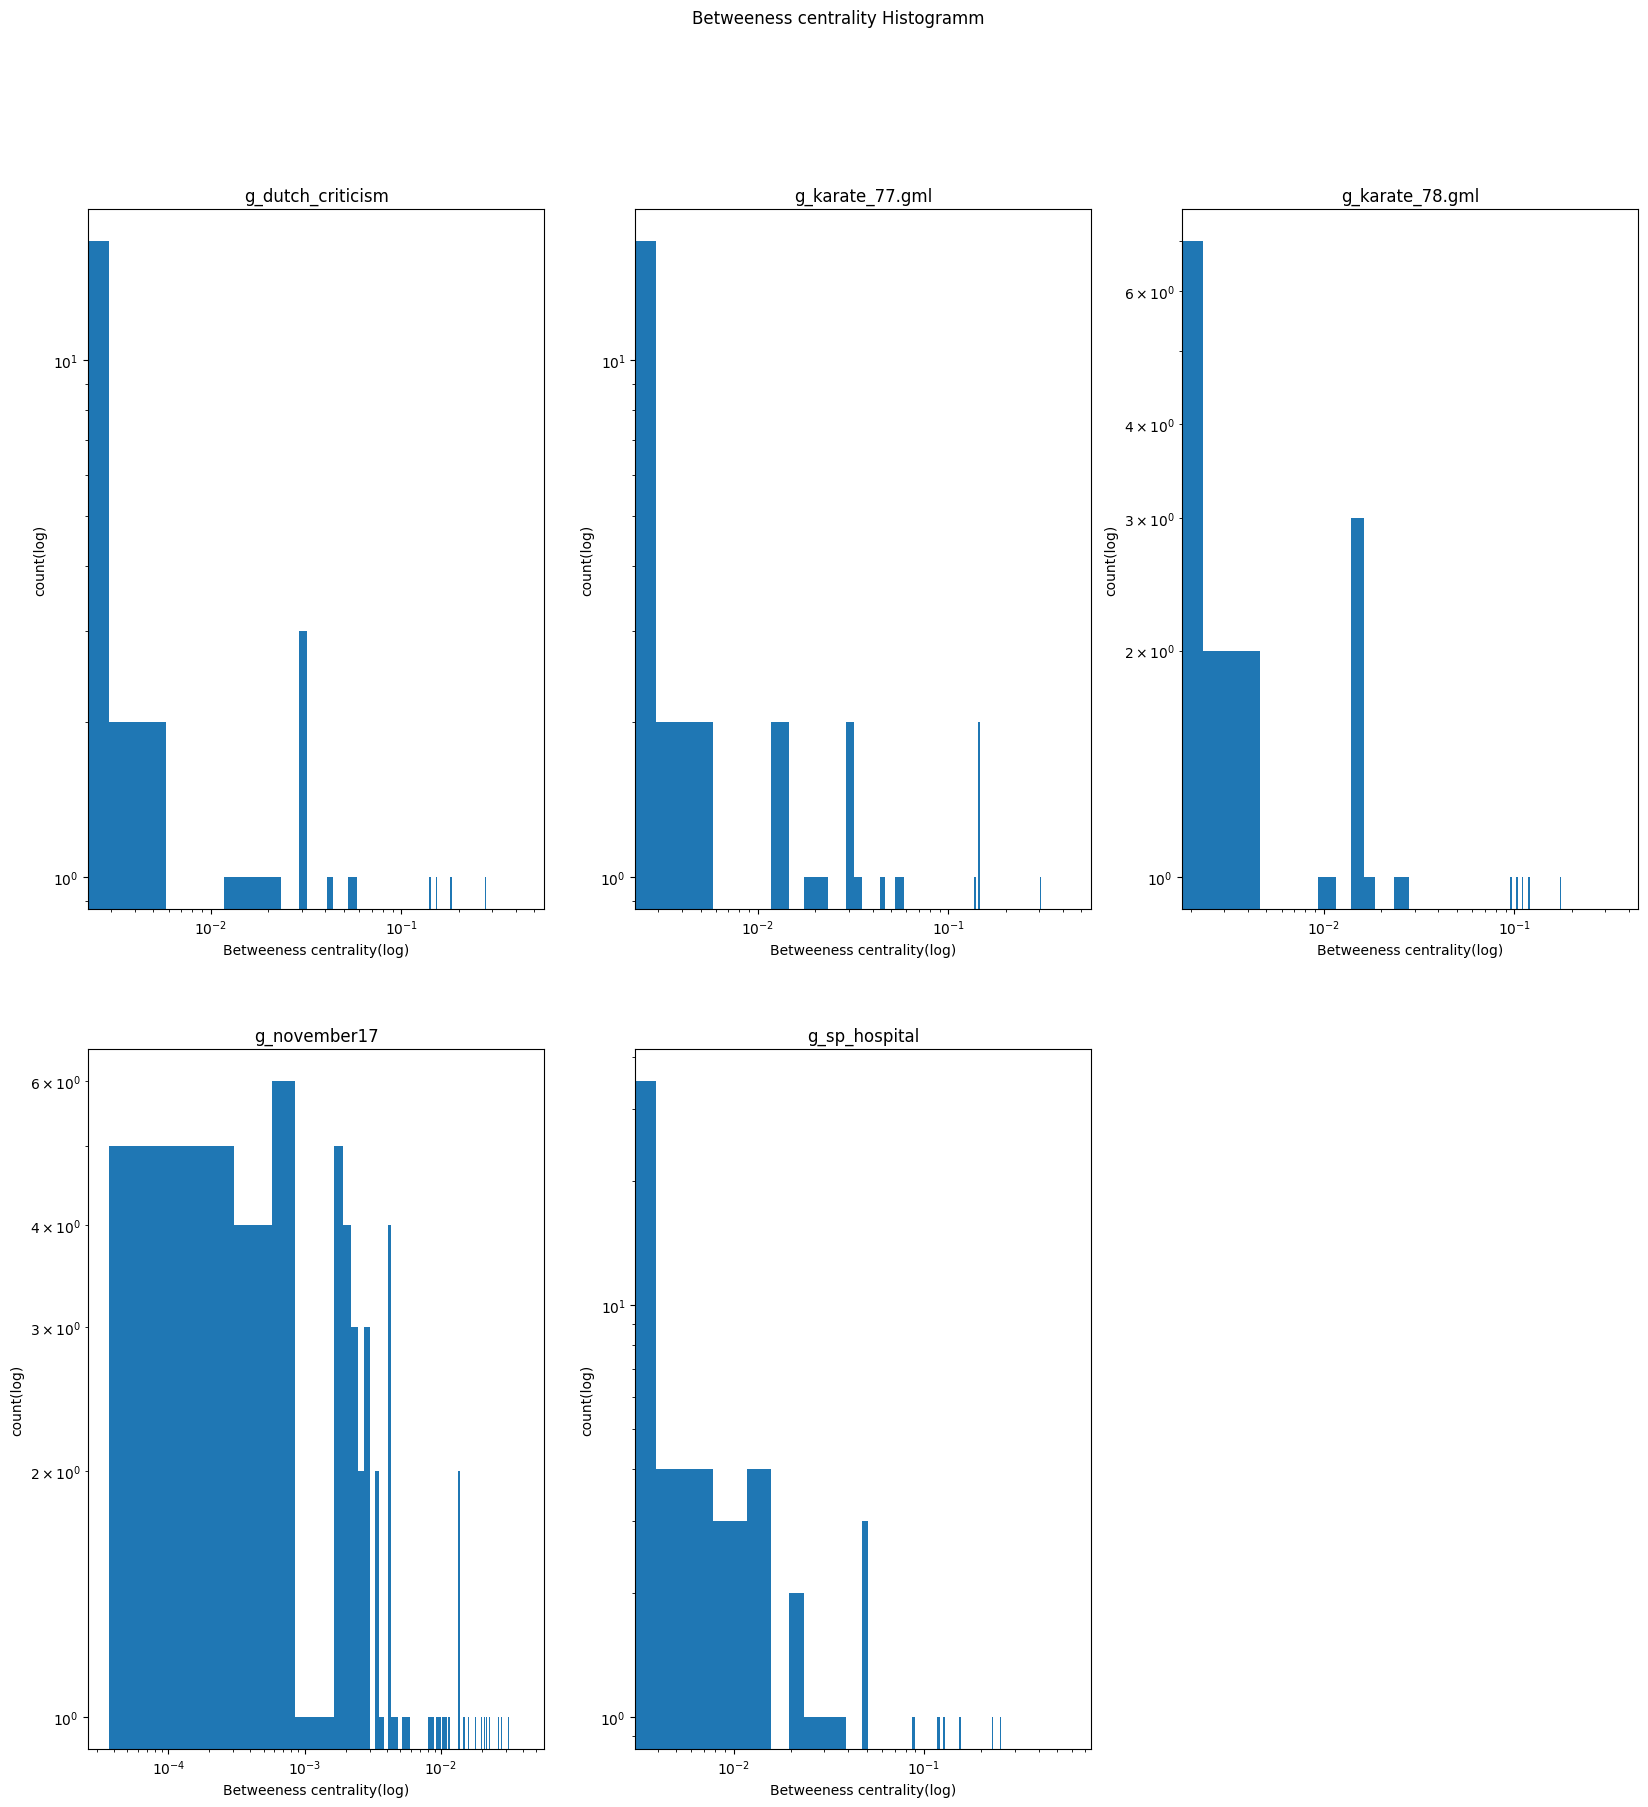

In [503]:
histogramm_plotter(graph_name_list,loaded_graphs_name_list, between_list,"Betweeness centrality","count","Betweeness centrality Histogramm",150)

#### 2.8.4 Closeness Centrality Histogramm

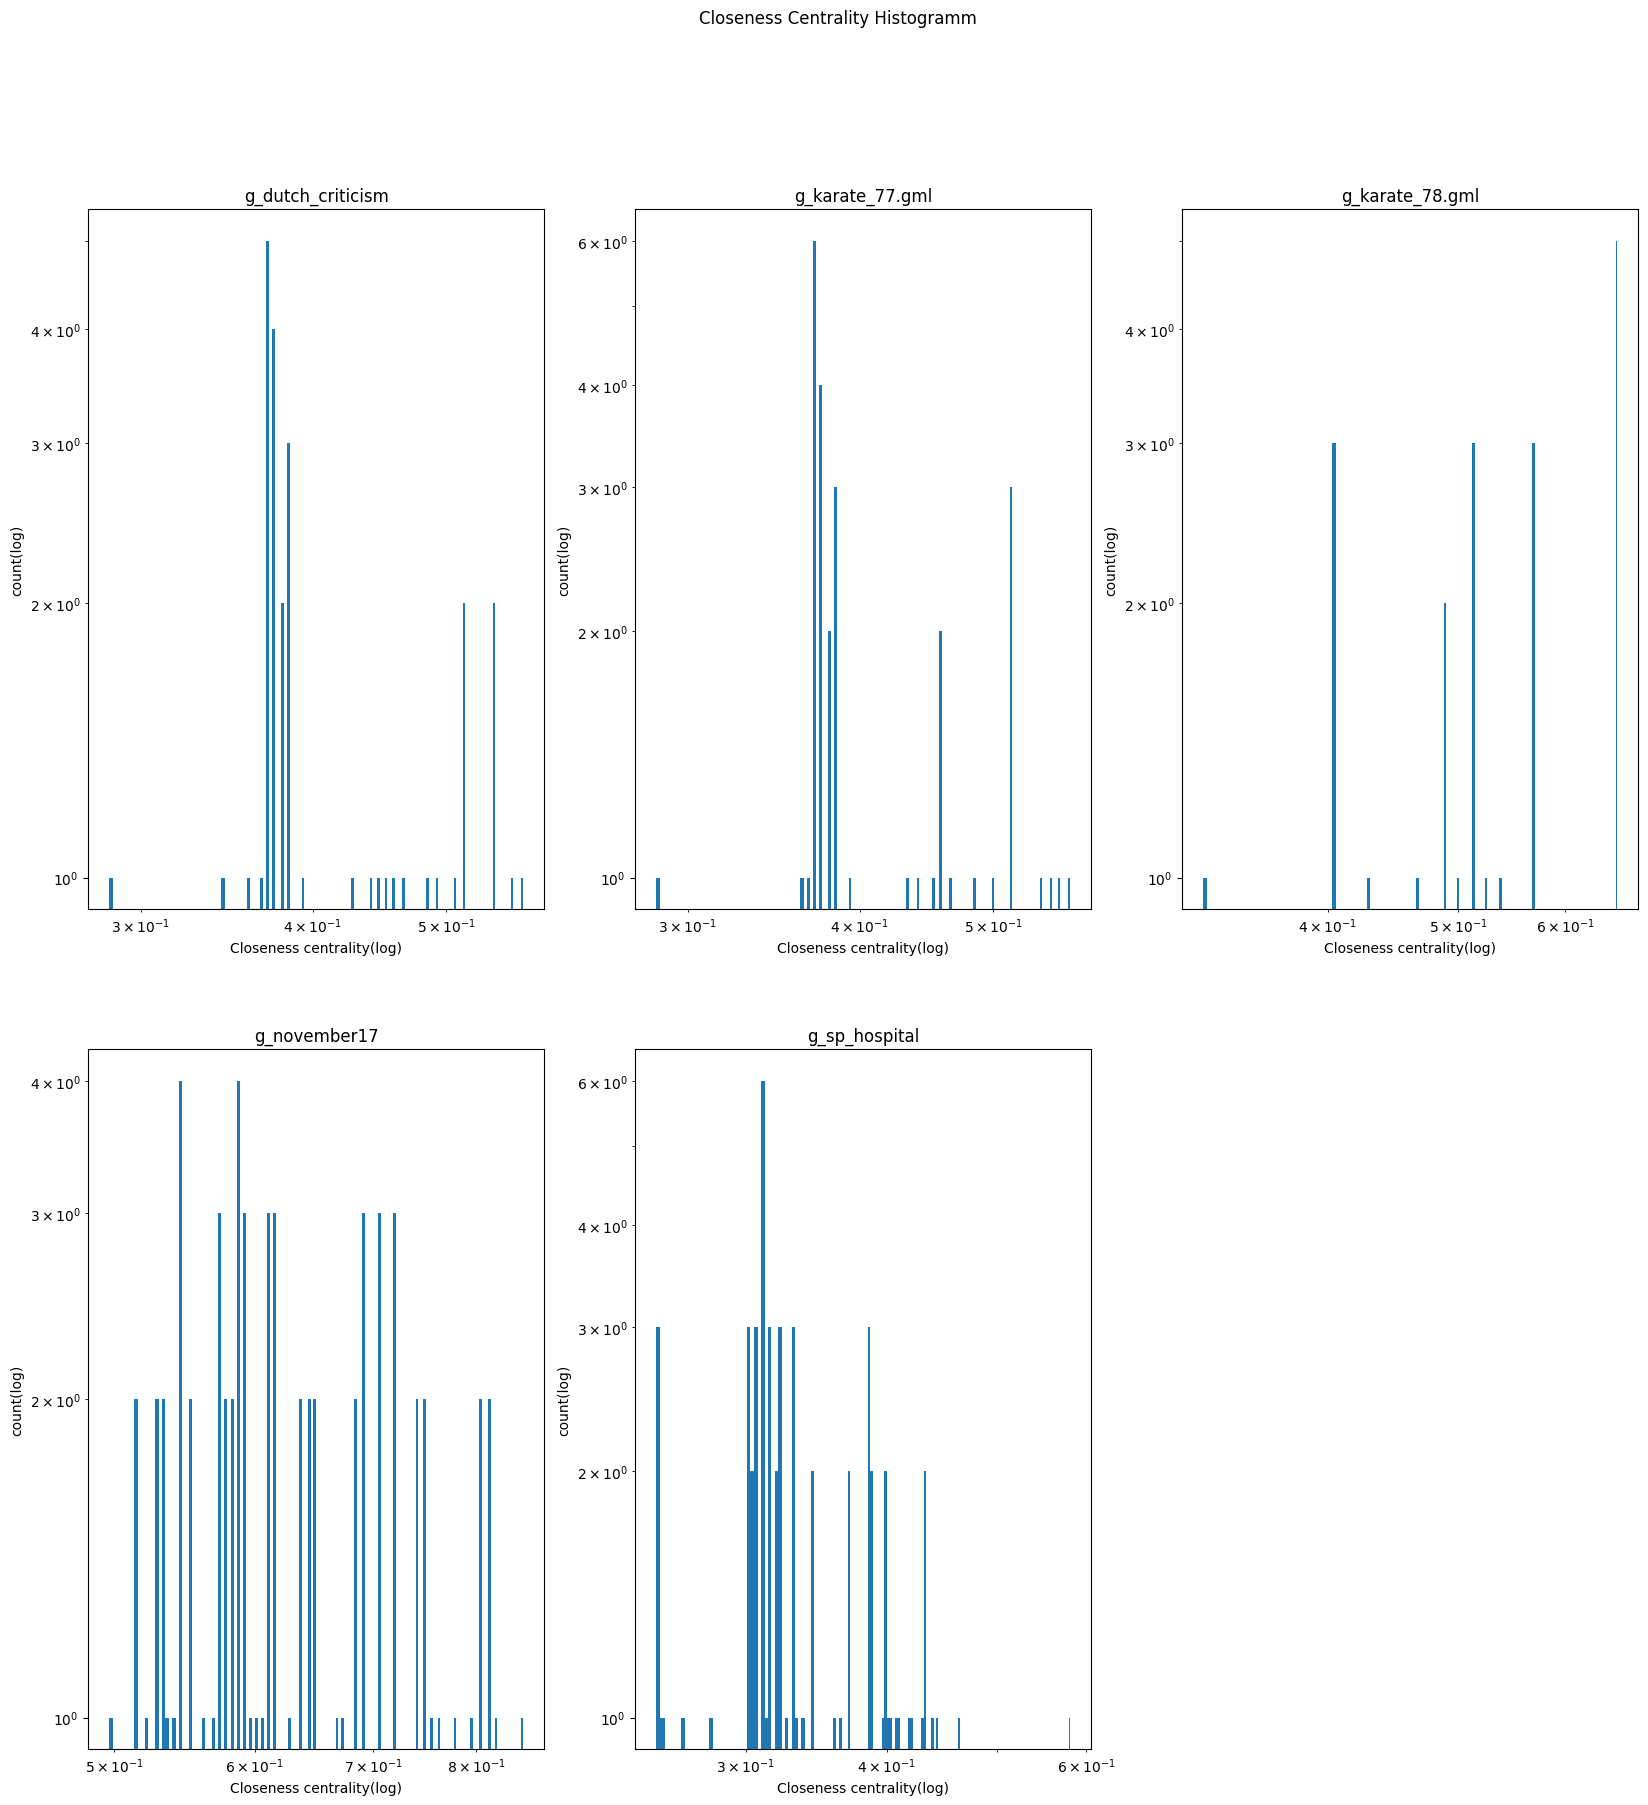

In [504]:
histogramm_plotter(graph_name_list,loaded_graphs_name_list, close_list,"Closeness centrality","count","Closeness Centrality Histogramm",150)